In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import duckdb
con = duckdb.connect()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 7.5
hm_h = 2.75
set_title = False

In [4]:
rg_cmap = sns.diverging_palette(20, 125, as_cmap=False)
green = rg_cmap[5]
red = rg_cmap[0]
rg_cmap

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

In [5]:
base_palette = sns.color_palette('tab10')
blue = base_palette[0]
orange = base_palette[1]
purple = base_palette[4]
base_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [6]:
systems = ['clickhouse', 'duckdb', 'hyper', 'monetdb', 'umbra']
palette = [green, orange, purple, blue, red]
markers = ['*', 'o', 'v', 's', '^']

In [7]:
def system_case(s):
    if s == 'duckdb':
        return 'DuckDB'
    elif s == 'umbra':
        return 'Umbra'
    elif s == 'monetdb':
        return 'MonetDB'
    elif s == 'clickhouse':
        return 'ClickHouse'
    elif s == 'hyper':
        return 'HyPer'
    else:
        return s

In [8]:
def fix_ylim(ax):
    min_y = 1e99
    for col in ax.collections:
        min_y = min(min_y, col.get_offsets()[0][1])
    diff = ax.get_ylim()[0] - min_y
    ax.set_ylim(bottom=diff)

In [9]:
def parse_cs_csv():
    q = []
    for sys in systems:
        for sf in [10, 100]:
            q.append(f"""
                      select column0 as q, column1 as time, '{system_case(sys)}' as system, {sf} as sf
                      from read_csv_auto('../results/{sys}/tpcds/sf{sf}/catalog_sales/results.csv')
                      """)
    q = " UNION ALL ".join(q)
    con.execute(f"""
    with csv_cte as (
        {q}
    ), fixed as (
        select string_split(q, 'sorting')[2]::INT q, time, system, sf
        from csv_cte
    )
    select q, median(time) as time, system, sf
    from fixed
    group by q, system, sf
    """)
    return con.fetchdf()

In [10]:
def parse_c_csv():
    q = []
    for sys in systems:
        for sf in [100, 300]:
            q.append(f"""
                      select column0 as q, column1 as time, '{system_case(sys)}' as system, {sf} as sf
                      from read_csv_auto('../results/{sys}/tpcds/sf{sf}/customer/results.csv')
                      """)
    q = " UNION ALL ".join(q)
    con.execute(f"""
    with csv_cte as (
        {q}
    )
    select case when q = 'sort_ints' then 'integer' else 'string' end as q,
           median(time) as time, system, sf
    from csv_cte
    group by q, system, sf
    """)
    return con.fetchdf()

# Catalog Sales

In [11]:
cs_df = parse_cs_csv()
cs_df.head()

,q,time,system,sf
0,1,0.515370,ClickHouse,10
1,2,1.946209,ClickHouse,10
2,3,2.517364,ClickHouse,10
3,4,2.636477,ClickHouse,10
4,1,3.942495,ClickHouse,100


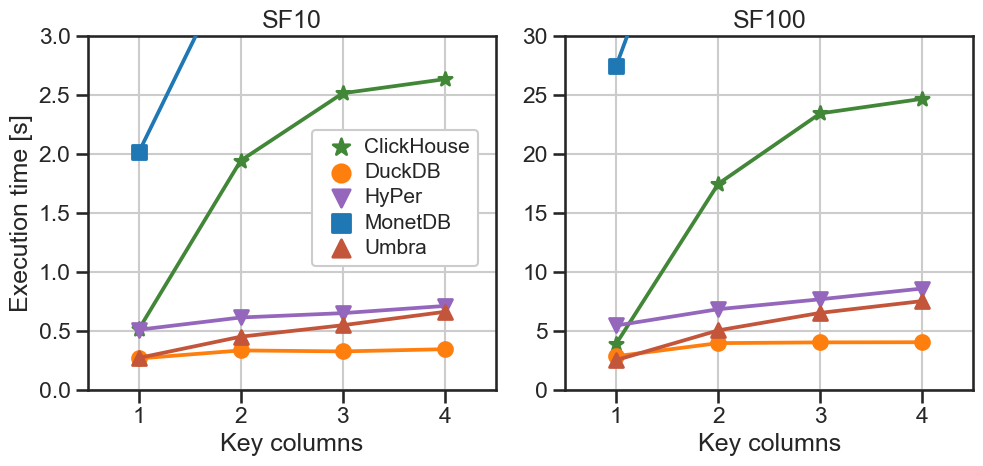

In [12]:
with plt.rc_context({'lines.linewidth': 1.5}):
    plot = sns.catplot(data=cs_df, col='sf', kind='point', markers=markers, x='q', y='time',
                       hue='system', sharey=False, sharex=True, col_wrap=2,
                       palette=palette, facet_kws=dict(despine=False))

for i, ax in enumerate(plot.axes):
    ax.set_ylabel('Execution time [s]')
    
    fix_ylim(ax)
    if i == 0:
        ax.set_title('SF10')
        ax.set_ylim(0, 3)
    else:
        ax.set_title('SF100')
        ax.set_ylabel('')
        ax.set_ylim(0, 30)
    ax.set_xlabel('Key columns')
    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([100])

for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
    
plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()

with plt.rc_context({'legend.markerscale': 1.25}):
    lgnd = plot.axes[0].legend(handles=handles, labels=labels, frameon=True, framealpha=1, loc=(0.55, 0.35),
                              fontsize=15, labelspacing=0.3, handletextpad=0.1)

plt.savefig('figs_icde/catalog_sales.eps', bbox_inches="tight")
plt.show()

In [28]:
cs_df
con.execute("""
select q, system, sf,
       round(time / (select time from cs_df i where i.system = o.system and i.sf = o.sf and i.q = 1), 2) as slowdown
from cs_df o
where o.q != 1
""")
slowdown_df = con.fetchdf()

In [32]:
con.execute("""
with cte2 as (
    select system, sf, slowdown, q
    from slowdown_df
    where q = 2
), cte3 as (
    select system, sf, slowdown, q
    from slowdown_df
    where q = 3
), cte4 as (
    select system, sf, slowdown, q
    from slowdown_df
    where q = 4
)
select cte2.system, cte2.sf, cte2.slowdown as q2, cte3.slowdown as q3, cte4.slowdown as q4
from cte2, cte3, cte4
where cte2.system = cte3.system
  and cte3.system = cte4.system
  and cte2.sf = cte3.sf
  and cte3.sf = cte4.sf
order by cte2.sf, cte2.system
""")
pivoted_slowdown_df = con.fetchdf()

In [37]:
con.execute("""
with sf10 as (
    select *
    from pivoted_slowdown_df
    where sf = 10
), sf100 as (
    select *
    from pivoted_slowdown_df
    where sf = 100
)
select sf10.system,
       sf10.q2 as s10_q2, sf10.q3 as s10_q3, sf10.q4 as s10_q4,
       sf100.q2 as s100_q2, sf100.q3 as s100_q3, sf100.q4 as s100_q4
from sf10, sf100
where sf10.system = sf100.system
""")
final_slowdown_df = con.fetchdf()
print(final_slowdown_df.to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
    system &  s10\_q2 &  s10\_q3 &  s10\_q4 &  s100\_q2 &  s100\_q3 &  s100\_q4 \\
\midrule
ClickHouse &    3.78 &    4.88 &    5.12 &     4.44 &     5.95 &     6.26 \\
    DuckDB &    1.25 &    1.22 &    1.29 &     1.39 &     1.41 &     1.41 \\
     HyPer &    1.20 &    1.27 &    1.39 &     1.25 &     1.41 &     1.57 \\
   MonetDB &    1.88 &    2.54 &    2.99 &     1.85 &     2.39 &     2.75 \\
     Umbra &    1.66 &    2.02 &    2.43 &     1.99 &     2.57 &     2.96 \\
\bottomrule
\end{tabular}



# Customer

In [13]:
c_df = parse_c_csv()
c_df.head()

,q,time,system,sf
0,integer,0.157860,ClickHouse,100
1,string,0.419012,ClickHouse,100
2,integer,0.374041,ClickHouse,300
3,string,1.072873,ClickHouse,300
4,integer,0.055006,DuckDB,100


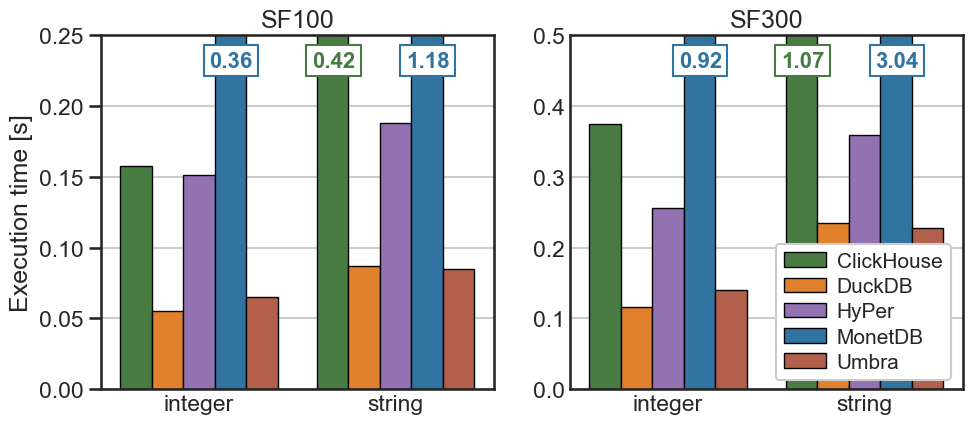

In [80]:
kwargs = {'linewidth': 1, 'edgecolor': 'black'}
plot = sns.catplot(data=c_df, col='sf', kind='bar', x='q', y='time', hue='system',
                   sharey=False, sharex=False, col_wrap=2, palette=palette, facet_kws=dict(despine=False),
                   **kwargs)

for i, ax in enumerate(plot.axes):
    if i == 0:
        ax.set_ylabel('Execution time [s]')
        ax.set_title('SF100')
        ax.set_ylim(0, 0.25)
    else:
        ax.set_title('SF300')
        ax.tick_params(axis='y', which='major', length=0)
        ax.set_ylim(0, 0.5)
    ax.tick_params(axis='x', which='major', length=0)
    ax.set_xlabel('')
    for rect in ax.patches:
        h = rect.get_height()
        ylim = ax.get_ylim()[1]
        if h < ylim:
            continue
        c = rect._original_facecolor
        draw_y = 0.9 * ylim
        ax.text(rect.get_x() + rect.get_width()/1.9, draw_y, f"{h:.2f}", ha='center', va='bottom',
                fontsize=16, bbox=dict(facecolor='white', edgecolor=c),
                fontweight='bold', color=c)

plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
with plt.rc_context({'legend.markerscale': 1.0}):
    lgnd = plot.axes[1].legend(handles=handles, labels=labels, frameon=True, loc=(0.525, 0.025), framealpha=1,
                               fontsize=15, labelspacing=0.3, handletextpad=0.5)

plt.savefig('figs_icde/key_type.eps', bbox_inches="tight")
plt.show()

In [78]:
con.execute("""
with strings as (
    select *
    from c_df
    where q = 'string'
), integers as (
    select * from c_df
    where q = 'integer'
)
select strings.system, strings.sf,
       round(strings.time / integers.time, 2) as slowdown
from strings, integers
where strings.system = integers.system
  and strings.sf = integers.sf
""")
con.fetchdf()

,system,sf,slowdown
0,ClickHouse,100,2.65
1,ClickHouse,300,2.87
2,DuckDB,100,1.58
3,DuckDB,300,2.03
4,HyPer,100,1.24
5,HyPer,300,1.40
6,MonetDB,100,3.25
7,MonetDB,300,3.33
8,Umbra,100,1.30
9,Umbra,300,1.62


# Random Integers & Floats

In [101]:
def parse_int_or_float_csv(dt):
    q = []
    for sys in systems:
        q.append(f"""
                  select '{dt}' as data_type, column0 as q, column1 as time, '{system_case(sys)}' as system
                  from read_csv_auto('../results/{sys}/rand{dt}s/results.csv')
                  """)
    q = " UNION ALL ".join(q)
    con.execute(f"""
    with csv_cte as (
        {q}
    )
    select data_type, cast(q as int) q, median(time) as time, system
    from csv_cte
    where try_cast(q as int) not NULL
    group by data_type, q, system
    """)
    return con.fetchdf()

In [131]:
ints_df = parse_int_or_float_csv('int')
ints_df.head()

,data_type,q,time,system
0,int,10,0.802136,ClickHouse
1,int,100,7.689672,ClickHouse
2,int,20,1.590934,ClickHouse
3,int,30,2.342847,ClickHouse
4,int,40,3.089728,ClickHouse


In [132]:
floats_df = parse_int_or_float_csv('float')
floats_df.head()

,data_type,q,time,system
0,float,10,0.873930,ClickHouse
1,float,100,9.267678,ClickHouse
2,float,20,1.785407,ClickHouse
3,float,30,2.767469,ClickHouse
4,float,40,3.694889,ClickHouse


In [133]:
con.execute("""
select * from ints_df
union all
select * from floats_df
""")
ints_and_floats_df = con.fetchdf()

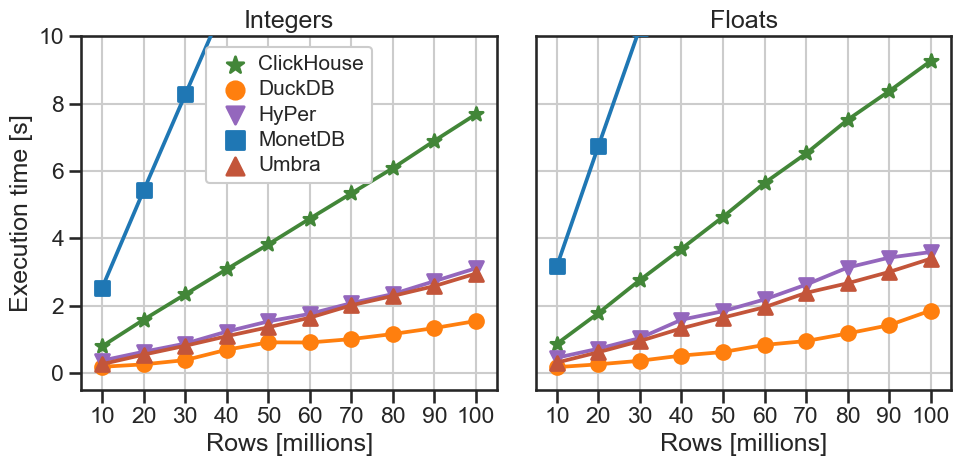

In [195]:
with plt.rc_context({'lines.linewidth': 1.5}):
    plot = sns.catplot(data=ints_and_floats_df, kind='point', markers=markers, x='q', y='time',
                       hue='system', col='data_type', palette=palette,
                       facet_kws=dict(despine=False), sharey=True)

for i, ax in enumerate(plot.axes[0]):
    if i == 0:
        ax.set_ylabel('Execution time [s]')
        ax.set_title('Integers')
    else:
        ax.set_title('Floats')
        ax.tick_params(axis='y', which='major', length=0)
    ax.set_xlabel('Rows [millions]')
    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([100])
    ax.set_ylim(-0.5, 10)

for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
    
plot._legend.set_visible(False)
handles, labels = plot.axes[0][0].get_legend_handles_labels()

with plt.rc_context({'legend.markerscale': 1.25}):
    lgnd = plot.axes[0][0].legend(handles=handles, labels=labels, frameon=True, framealpha=1, loc='upper center',
                                 fontsize=15, labelspacing=0.3, handletextpad=0.1)

plt.savefig('figs_icde/randints.eps', bbox_inches="tight")
plt.show()

In [18]:
# DuckDB single thread: 9.452